**IMPORTING REQUIRED LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import pathlib
from pathlib import Path
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils  import to_categorical
from keras.preprocessing.image import ImageDataGenerator


In [2]:
data_dir='/kaggle/input/potato-leaf-disease'
root_dir='/kaggle/working/'

In [3]:
def countfiles(root_dir):
    for path in pathlib.Path(root_dir).iterdir():
        if path.is_dir():
             print( str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files inside the " + \
            str(path.name),'class')
countfiles(data_dir)

1000 files inside the Potato___healthy class
1000 files inside the Potato___Late_blight class
1000 files inside the Potato___Early_blight class


**DATASET PREPARATION**

In [11]:
def data_categories(d_path):
    categories=[]    #listdir-->used to get the list of all files and directories in the specified directory
    for folder_name in os.listdir(d_path):  #os.path.isdir()--->used to check whether the specified path is an existing directory or not.
        if os.path.isdir(os.path.join(d_path,folder_name)):
            no_of_files=len(glob.glob(os.path.join(d_path, folder_name)+"/*.JPG"))
            categories.append(np.array([folder_name,no_of_files]))
    categories.sort(key=lambda a:a[0])
    cat=np.array(categories)
    return list(cat[:, 0]),list(cat[:,1])
categories,no_of_files = data_categories("/kaggle/input/potato-leaf-disease")
print(categories)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [12]:
print("number of categories: ", len(categories))

number of categories:  3


In [13]:
df = pd.DataFrame({"category": categories, "number of files": no_of_files})
df

,category,number of files
0,Potato___Early_blight,1000
1,Potato___Late_blight,1000
2,Potato___healthy,1000


In [14]:
def dataset(data_path, categories, width, height):
    x = []
    y = []
    for category_idx, category in enumerate(categories):
        path = os.path.join(data_path, category)
        count = 0
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            img_size = cv2.resize(img_array, (width, height))
            x.append(img_size)
            y.append(category_idx)
            count += 1
        print(f"Number of images in class {category_idx}: {count}")
    y = np.array(y)
    x = np.array(x).reshape(y.shape[0], width, height, 3)
    return x, y

x, y = dataset(data_path=data_dir, categories=['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'], width=100,height=100)


Number of images in class 0: 1000
Number of images in class 1: 1000
Number of images in class 2: 1000


In [15]:
print(f'x shape:{x.shape}')
print(f"y shape: {y.shape}")

x shape:(3000, 100, 100, 3)
y shape: (3000,)


**IMAGES FROM CLASSES**

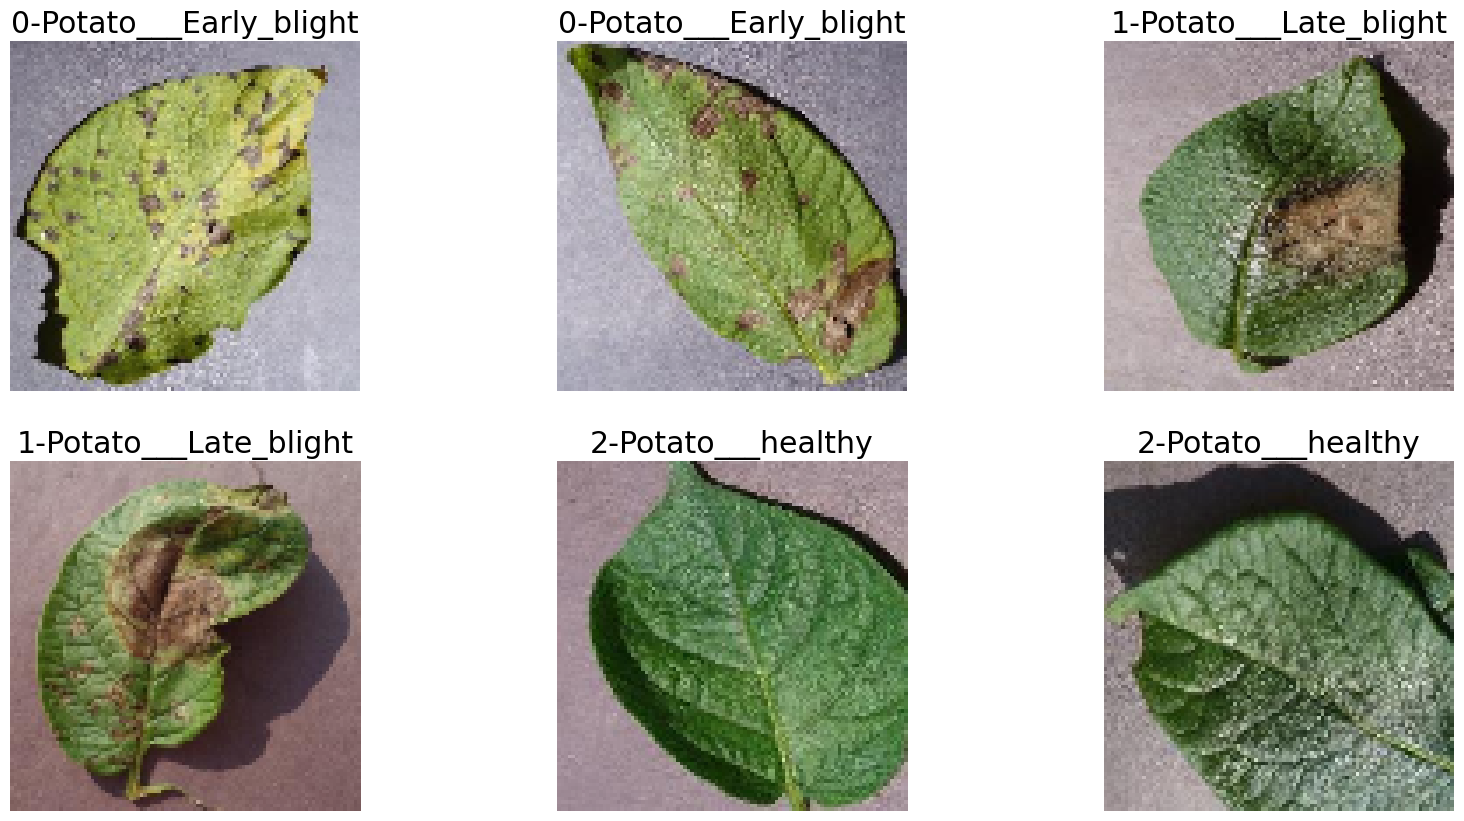

In [18]:
plt.figure(figsize=(20, 10))
st, end = 0,500
for i in range(6):
    plt.subplot(2, 3, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    plt.rcParams.update({'font.size':18})
    plt.imshow(x[idx][:, :, ::-1])
    plt.title(f"{y[idx]}-{categories[y[idx]]}")
    plt.axis("off")
plt.show()

**DATASET SPLITTING FOR TRAIN/VAL/TEST SETS**

In [19]:
y=np.reshape(y,(len(y),1))
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=42)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (2700, 100, 100, 3)
y_train: (2700, 1)
x_test: (300, 100, 100, 3)
y_test: (300, 1)


In [20]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,train_size=0.70)
x_test=x_test

print(f"x_train:{x_train.shape},y_train:{y_train.shape}")       
print(f"x_val: {x_val.shape},y_val:{y_val.shape}")        #70-20-10
print(f"x_test:{x_test.shape},y_test:{y_test.shape}")

x_train:(1889, 100, 100, 3),y_train:(1889, 1)
x_val: (811, 100, 100, 3),y_val:(811, 1)
x_test:(300, 100, 100, 3),y_test:(300, 1)


In [21]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_val:{x_val.shape},  y_val:{y_val.shape}")
print(f"x_test:{x_test.shape},  y_test:{y_test.shape}")

x_train:(1889, 100, 100, 3),  y_train:(1889, 3)
x_val:(811, 100, 100, 3),  y_val:(811, 3)
x_test:(300, 100, 100, 3),  y_test:(300, 3)


**DATA PREPROCESSING**

In [22]:
train_generator=ImageDataGenerator(rescale=1./255,
                                   rotation_range=2,
                                  horizontal_flip=True,
                                   shear_range=0.5,
                                  zoom_range=0.7)
val_generator=ImageDataGenerator(rescale=1./255,
                                 rotation_range=2,
                                 horizontal_flip=True,
                                 shear_range=0.5,
                                 zoom_range=0.1)
test_generator=ImageDataGenerator(rotation_range=2,
                                 horizontal_flip=True,
                                 zoom_range=0.1)

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

**MODEL BUILDING-CNN**

In [23]:
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense

In [42]:
model = keras.Sequential([
    # Convolutional layers 
                   #kernels,  #filters ,  #activation function,          #input
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
    
])


In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                 

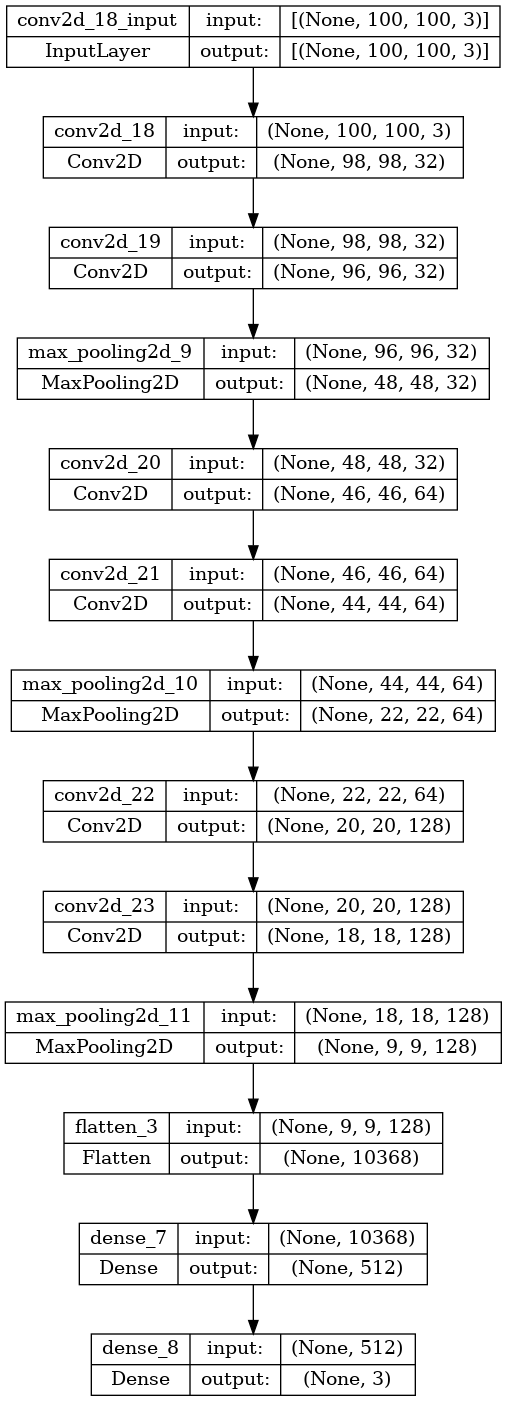

In [44]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,to_file='3class model.png')


In [45]:
from keras.metrics import Precision,Recall
import tensorflow_addons as tfa

In [46]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',Precision(name='precision'),Recall(name='Recall'),tfa.metrics.F1Score(num_classes=3)])

In [47]:
history = model.fit(x_train,y_train, epochs=30,batch_size=100,
                    validation_data = val_generator.flow(x_val,y_val,batch_size=100),
                   validation_steps=200,
                   verbose=1)
history=history.history
model.save('/kaggle/working/3c_model.h5')

Epoch 1/30
19/19 [==============================] - 6s 170ms/step - loss: 12.9609 - accuracy: 0.4060 - precision: 0.3937 - Recall: 0.1911 - f1_score: 0.4050 - val_loss: 1.0986 - val_accuracy: 0.3354 - val_precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_f1_score: 0.1674
Epoch 2/30
19/19 [==============================] - 1s 36ms/step - loss: 0.7701 - accuracy: 0.6548 - precision: 0.7339 - Recall: 0.5315 - f1_score: 0.6531
Epoch 3/30
19/19 [==============================] - 1s 36ms/step - loss: 0.3436 - accuracy: 0.8581 - precision: 0.8688 - Recall: 0.8449 - f1_score: 0.8569
Epoch 4/30
19/19 [==============================] - 1s 36ms/step - loss: 0.2577 - accuracy: 0.8999 - precision: 0.9014 - Recall: 0.8957 - f1_score: 0.8995
Epoch 5/30
19/19 [==============================] - 1s 36ms/step - loss: 0.4892 - accuracy: 0.7988 - precision: 0.8145 - Recall: 0.7856 - f1_score: 0.7963
Epoch 6/30
19/19 [==============================] - 1s 36ms/step - loss: 0.1956 - accuracy: 0.9201 - prec

**CNN MODEL EVALUATION**

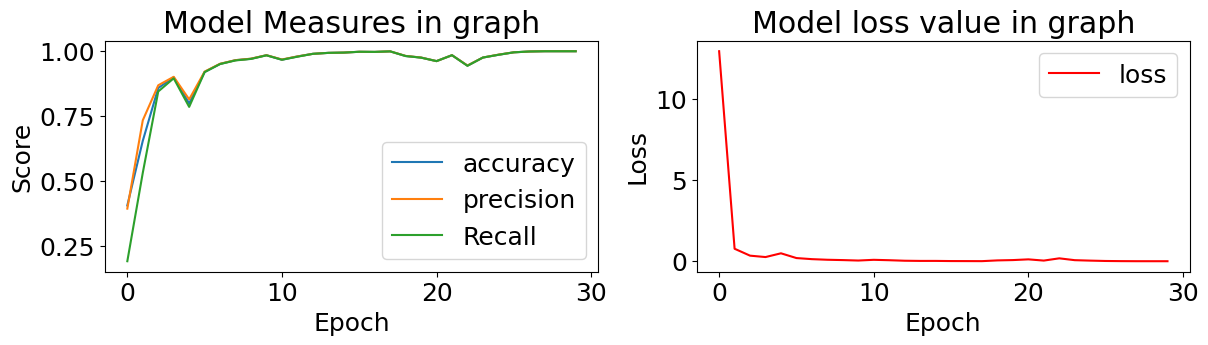

In [55]:
fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(history['accuracy'])
ax1.plot(history['precision'])
ax1.plot(history["Recall"])
ax1.legend(['accuracy','precision','Recall'])
ax1.set_title('Model Measures in graph')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Score')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(history['loss'],color='red')
ax2.legend(['loss'])
ax2.set_title('Model loss value in graph')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

plt.savefig('graph.png')
plt.show()

**TEST SET**

In [56]:
testscore=model.evaluate(x_test,y_test)
testscore

10/10 [==============================] - 0s 7ms/step - loss: 0.2006 - accuracy: 0.9567 - precision: 0.9567 - Recall: 0.9567 - f1_score: 0.9570


[0.20064330101013184,
 0.9566666483879089,
 0.9566666483879089,
 0.9566666483879089,
 array([0.9626168, 0.9353234, 0.972973 ], dtype=float32)]

In [50]:
print('TEST DATA')
print('')
print(f"Accuracy: {round(testscore[1]*100,2)}%")
print(f"Precision: {round(testscore[2]*100,2)}%")
print(f"Recall: {round(testscore[3]*100,2)}%")
print(f"F1_score: {testscore[4]}")
print(f"Loss: {testscore[0]}")

TEST DATA

Accuracy: 95.67%
Precision: 95.67%
Recall: 95.67%
F1_score: [0.9626168 0.9353234 0.972973 ]
Loss: 0.20064330101013184


In [51]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [57]:
y_pred=np.argmax(model.predict(x_test),axis=1)
y_true=np.argmax(y_test,axis=1)

10/10 [==============================] - 0s 4ms/step


In [58]:
c_test=confusion_matrix(y_true,y_pred)
c_test

array([[103,   4,   0],
       [  4,  94,   2],
       [  0,   3,  90]])

In [59]:
print(classification_report(y_true,y_pred,target_names=['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']))

                       precision    recall  f1-score   support

Potato___Early_blight       0.96      0.96      0.96       107
 Potato___Late_blight       0.93      0.94      0.94       100
     Potato___healthy       0.98      0.97      0.97        93

             accuracy                           0.96       300
            macro avg       0.96      0.96      0.96       300
         weighted avg       0.96      0.96      0.96       300



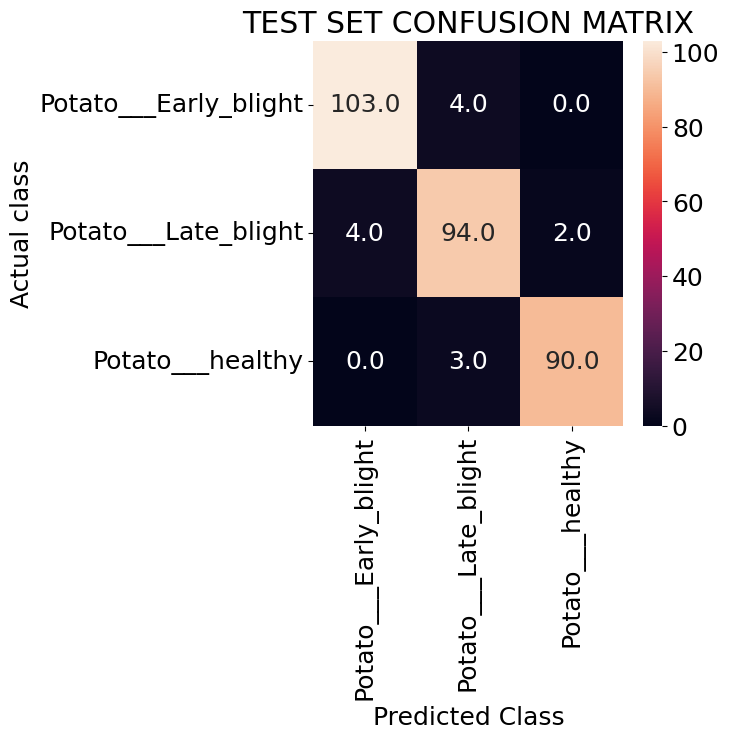

In [60]:
class_names=['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
plt.figure(figsize=(5,5))
sns.heatmap(c_test,annot=True,xticklabels=class_names,yticklabels=class_names,fmt='.1f')
plt.title('TEST SET CONFUSION MATRIX')
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.savefig('cm test.png')
plt.show()

In [61]:
print(f"TEST SET")
print('')
for i in range(3):
    tp = c_test[i, i]
    tn = np.sum(c_test) - np.sum(c_test[i, :]) - np.sum(c_test[:, i]) + c_test[i, i]
    fp = np.sum(c_test[:, i]) - c_test[i, i]
    fn = np.sum(c_test[i, :]) - c_test[i, i]
    print(f"Class {i}: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

TEST SET

Class 0: TP=103, TN=189, FP=4, FN=4
Class 1: TP=94, TN=193, FP=7, FN=6
Class 2: TP=90, TN=205, FP=2, FN=3


**VALIDATION SET ANALYSIS**

In [62]:
valscore=model.evaluate(x_val,y_val)
valscore

26/26 [==============================] - 0s 8ms/step - loss: 0.1532 - accuracy: 0.9593 - precision: 0.9593 - Recall: 0.9593 - f1_score: 0.9591


[0.1532370150089264,
 0.9593095183372498,
 0.9593095183372498,
 0.9593095183372498,
 array([0.9726776 , 0.93761814, 0.9669118 ], dtype=float32)]

In [63]:
print('VALIDATION DATA')
print('')
print(f"Accuracy: {round(valscore[1]*100,2)}%")
print(f"Precision: {round(valscore[2]*100,2)}%")
print(f"Recall: {round(valscore[3]*100,2)}%")
print(f"F1_score: {valscore[4]}")
print(f"Loss: {valscore[0]}")

VALIDATION DATA

Accuracy: 95.93%
Precision: 95.93%
Recall: 95.93%
F1_score: [0.9726776  0.93761814 0.9669118 ]
Loss: 0.1532370150089264


In [64]:
yv_pred=np.argmax(model.predict(x_val),axis=1)
yv_true=np.argmax(y_val,axis=1)

26/26 [==============================] - 0s 4ms/step


In [65]:
c_val=confusion_matrix(yv_true,yv_pred)
c_val

array([[267,  10,   0],
       [  5, 248,   9],
       [  0,   9, 263]])

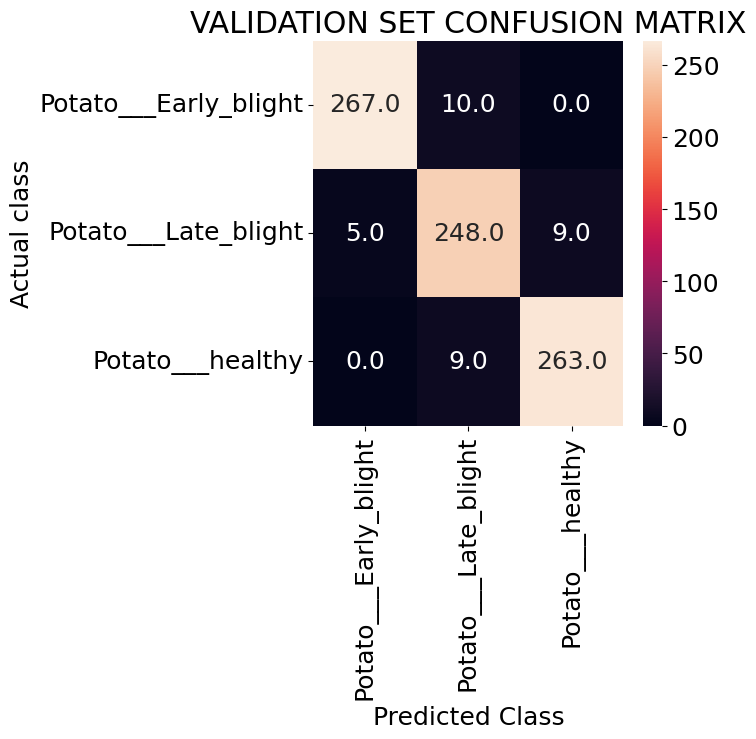

In [66]:
plt.figure(figsize=(5,5))
sns.heatmap(c_val,annot=True,xticklabels=class_names,yticklabels=class_names,fmt='.1f')
plt.title('VALIDATION SET CONFUSION MATRIX')
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.savefig('cm VAL.png')
plt.show()

In [68]:
print(classification_report(yv_true,yv_pred,target_names=class_names))

                       precision    recall  f1-score   support

Potato___Early_blight       0.98      0.96      0.97       277
 Potato___Late_blight       0.93      0.95      0.94       262
     Potato___healthy       0.97      0.97      0.97       272

             accuracy                           0.96       811
            macro avg       0.96      0.96      0.96       811
         weighted avg       0.96      0.96      0.96       811



In [69]:
print(f"VALIDATION SET")
print('')
for i in range(3):
    tp = c_val[i, i]
    tn = np.sum(c_val) - np.sum(c_val[i, :]) - np.sum(c_val[:, i]) + c_val[i, i]
    fp = np.sum(c_val[:, i]) - c_val[i, i]
    fn = np.sum(c_val[i, :]) - c_val[i, i]
    print(f"Class {i}: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

VALIDATION SET

Class 0: TP=267, TN=529, FP=5, FN=10
Class 1: TP=248, TN=530, FP=19, FN=14
Class 2: TP=263, TN=530, FP=9, FN=9


**IMAGE PREDICTIONS WITH PERCENTAGES**

1/1 [==============================] - 0s 38ms/step


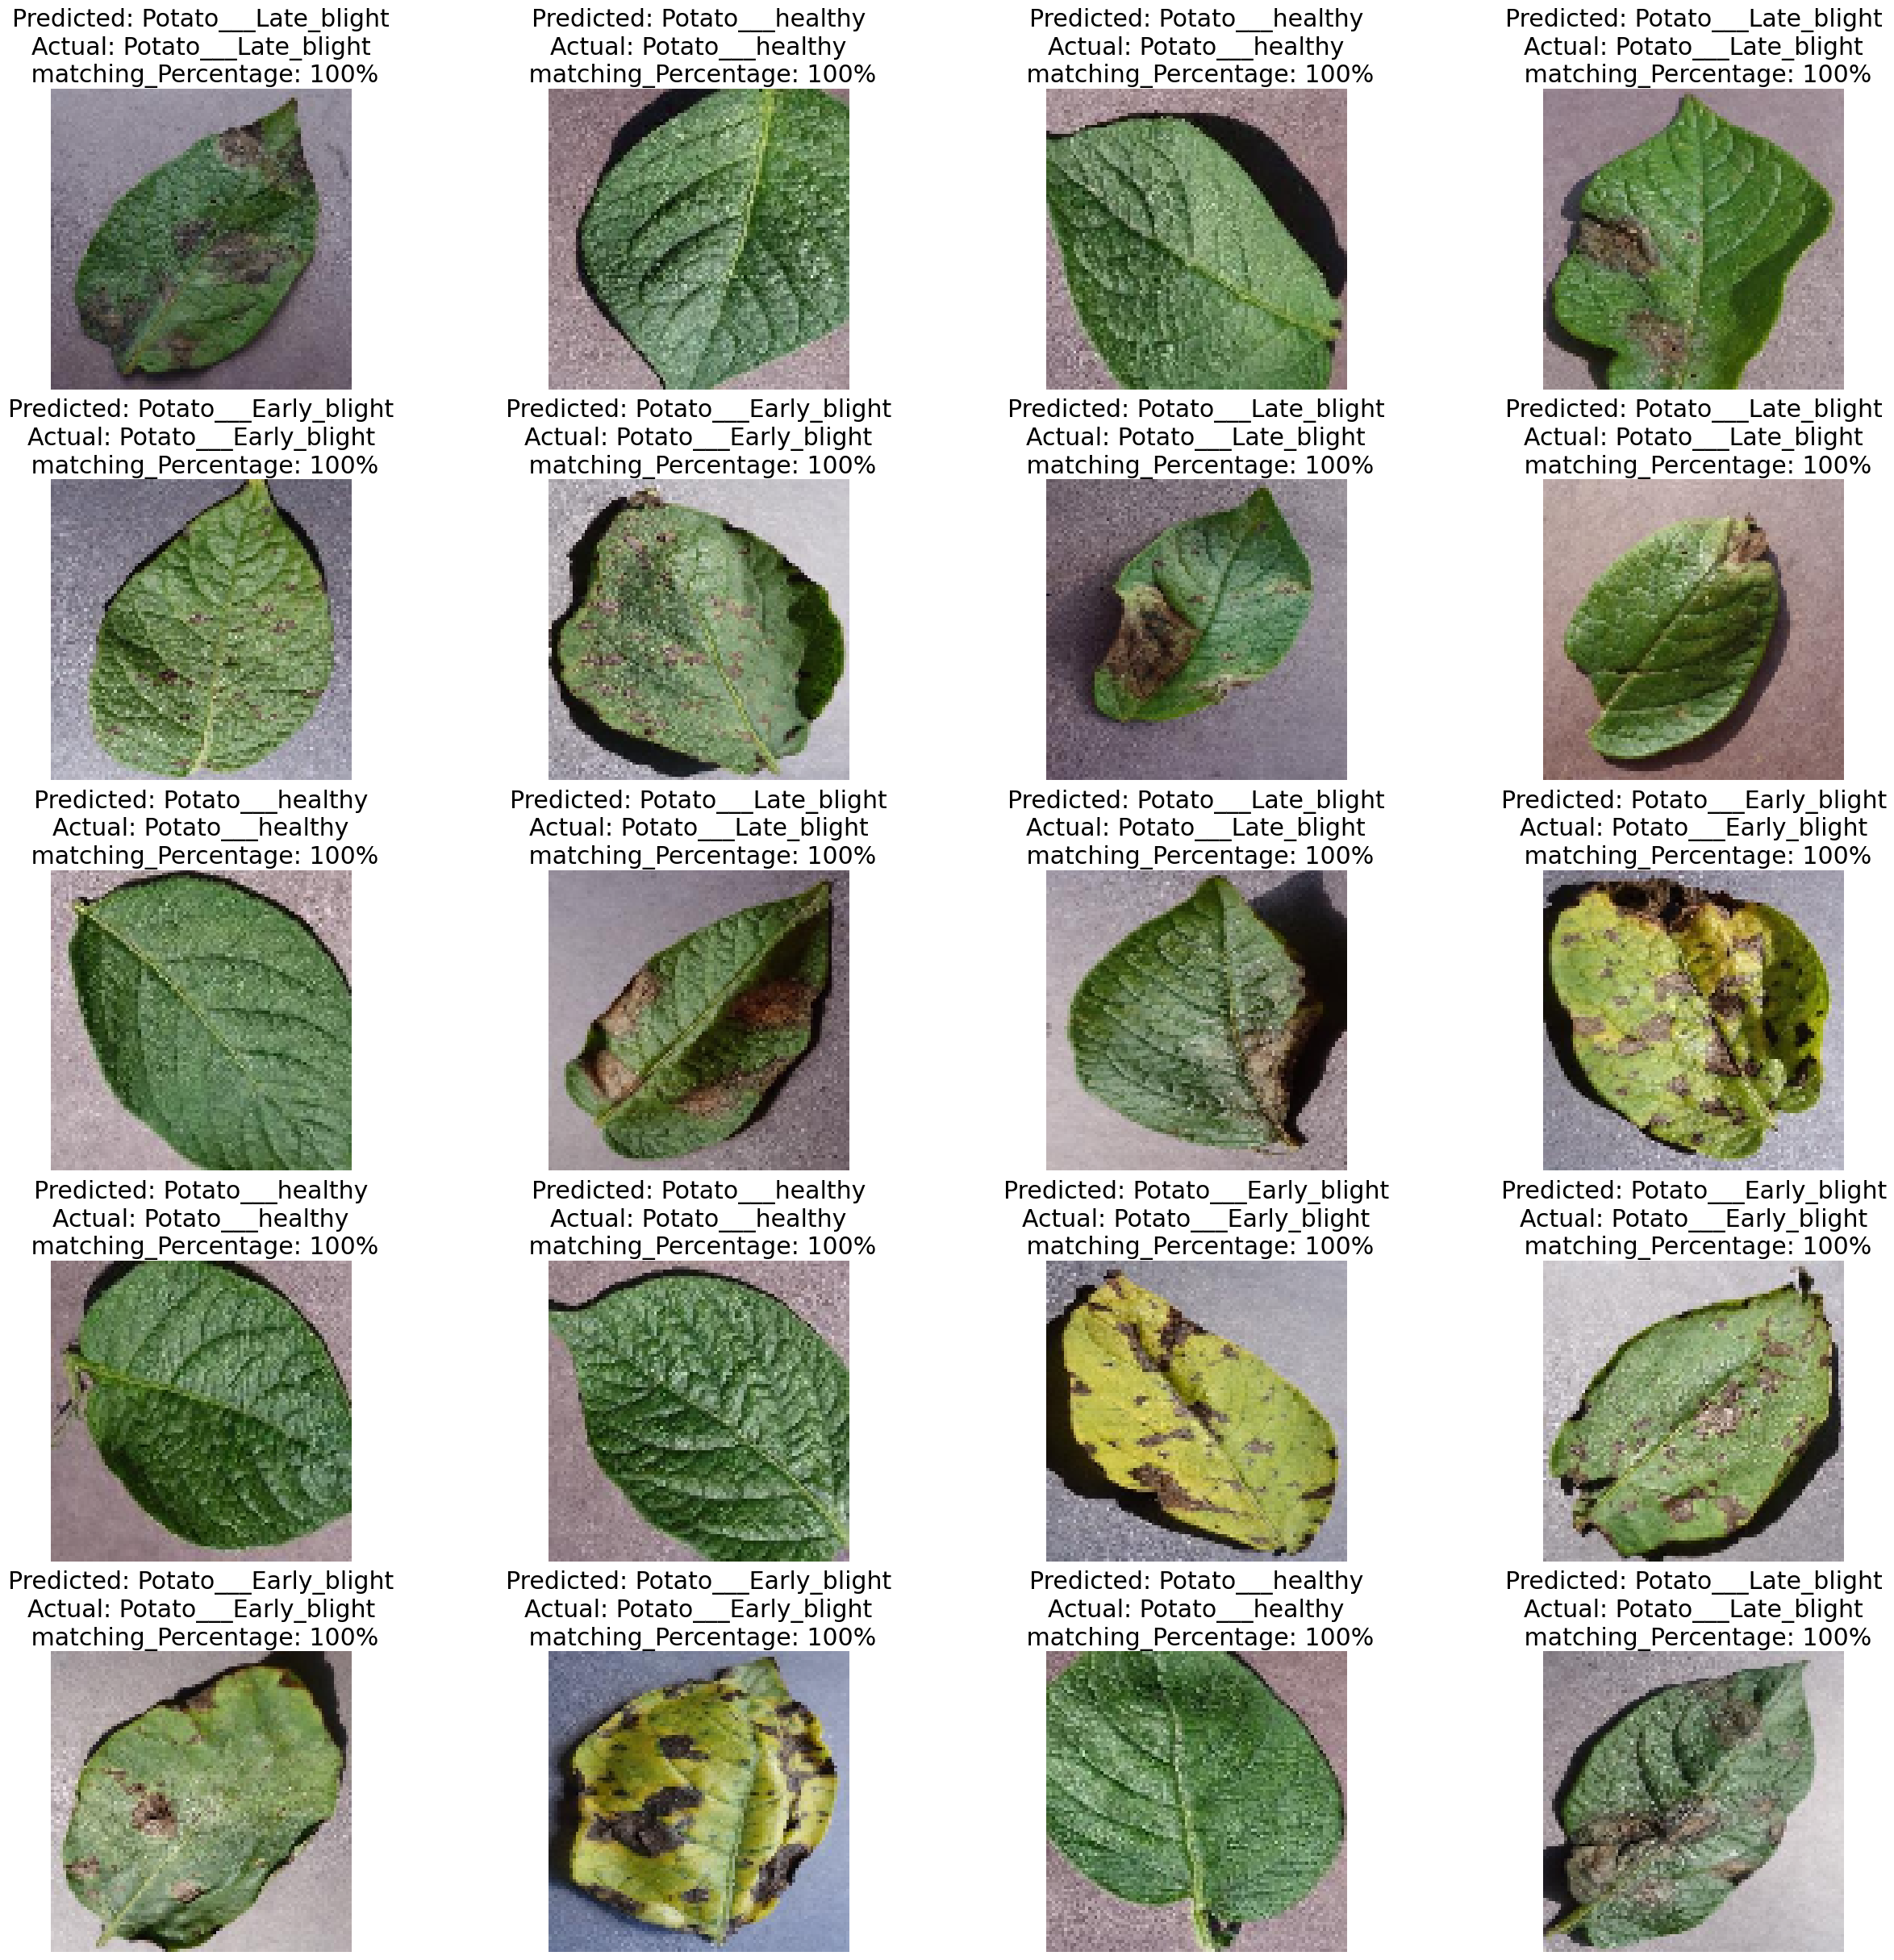

In [71]:

plt.figure(figsize=(30, 30))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i in range(20):
    idx = np.random.randint(len(y))
    img, true_class = x[idx], categories[y[idx].squeeze()]

    # predict class probabilities for the current image
    probs = model.predict(img[None, :, :, :])[0]
    pred_class = categories[np.argmax(probs)]
    max_prob = np.max(probs)*100
    plt.rcParams.update({'font.size':18})
    plt.subplot(5, 4, i + 1)
    plt.imshow(img[:, :, ::-1])
    plt.title(f"Predicted: {pred_class}\nActual: {true_class}\n matching_Percentage: {round(max_prob)}%")
    plt.axis("off")
plt.show()